What this notebook does:

LDA models with varying numbers of topics are fit to the collection of coffeeshop reviews, where each review is represented by only its lemmatized nouns.  The lemmatized reviews are found in './ProcessedData/lemmatizedreviews.csv'

Models are evaluated on coherence and perplexity, and human interpretability of the top words. The 5 topic model was best in terms of coherence (0.52), but better perplexities were found for models with greater numbers of topics.

4 and 5 topic gensim LDA models, and the associated dictionary are saved.


In [1]:
#Step one directory up to access the yelp scraping function in the helper_functions module
import os
print(os.getcwd())
os.chdir('../')
os.getcwd()

/Users/thomasyoung/Dropbox/TYInsightProject/LDA_Fitting


'/Users/thomasyoung/Dropbox/TYInsightProject'

In [2]:
import numpy as np
import pandas as pd

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import LdaModel
from gensim.test.utils import datapath
from gensim import corpora

import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_lg

from tqdm import tqdm_notebook as tqdm
from pprint import pprint

import re

# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

#For visualizing the LDA topics
import pickle

import pyLDAvis.gensim


import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/thomasyoung/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [32]:
shops = pd.read_csv('./ProcessedData/coffeeshops_withcfcutoff.csv')
reviews = pd.read_csv('./ProcessedData/lemmatizedreviews.csv')
merged = pd.merge(shops,reviews,how='inner',on = ['alias'])
print('shape of lemmatized review dataframe')
print(reviews.shape)

print('number of unique coffeeshops')
print(merged.alias.nunique())

print('number of unique review texts')
print(merged.reviewtxt.nunique())

(46077, 10)
(46077, 33)
(791,)
791
46077


In [33]:
shops[shops.ntacode=='MN22'].alias.value_counts()

coffee-project-new-york-new-york-3      1
bluestone-lane-new-york-9               1
saltwater-coffee-new-york               1
third-rail-coffee-new-york-2            1
starbucks-new-york-180                  1
starbucks-new-york-210                  1
everyman-espresso-new-york              1
atlas-cafe-and-bakery-new-york-2        1
book-club-new-york                      1
kona-coffee-and-company-new-york        1
starbucks-new-york-109                  1
the-lazy-llama-coffee-bar-new-york-2    1
dunkin-new-york-45                      1
think-coffee-new-york-3                 1
future-you-café-new-york                1
dunkin-new-york-25                      1
787-coffee-new-york-2                   1
elsewhere-espresso-new-york             1
c-and-b-new-york                        1
roastown-coffee-new-york                1
mudpark-new-york                        1
hi-collar-new-york-2                    1
dunkin-new-york-34                      1
porto-rico-importing-co-new-york-3

6.0     3123
7.0     2983
5.0     2973
8.0     2811
4.0     2653
9.0     2499
10.0    2377
11.0    2169
3.0     1938
12.0    1905
13.0    1795
14.0    1595
15.0    1413
16.0    1283
17.0    1151
18.0    1046
2.0     1045
19.0     980
20.0     882
21.0     759
Name: review_lem_noun, dtype: int64

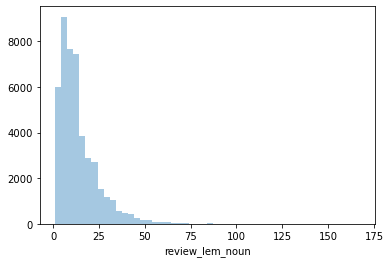

In [34]:

data_lemmatized = merged.review_lem_noun.str.split(' ')
sns.distplot(data_lemmatized.str.len(),kde=False)
data_lemmatized.str.len().value_counts().head(20)

In [35]:

merged = merged[data_lemmatized.str.len() > 3]
data_lemmatized = merged.review_lem_noun.str.split(' ').to_list()
print(data_lemmatized[0:3])


[['nighttime', 'bar', 'vibe', 'vibe', 'price', 'bank', 'table', 'wait', 'seat', 'spot', 'date', 'couple', 'friend', 'dinner', 'drink', 'drink'], ['spritz', 'commissary', 'canal', 'hip', 'atmosphere', 'pretense', 'cafe', 'way', 'night', 'wine', 'bar', 'selection', 'beer', 'spritz', 'case', 'spritzer', 'usage', 'makeup', 'cappelletti', 'flavor', 'bubble', 'gum', 'quality', 'taste', 'comparison', 'perfection', 'wine', 'range', 'server', 'water', 'self', 'corner', 'chill', 'place', 'crowd', 'price', 'wine', 'person', 'hit', 'step', 'dive', 'step', 'hipster', 'wine', 'bar', 'spot', 'ground', 'bonus', 'place'], ['gallery', 'beer', 'hummus', 'sandwich', 'day', 'sort', 'way', 'service'], ['music', 'choice', 'spot', 'work', 'latte'], ['work', 'paper', 'table', 'laptop', 'waiter', 'difference', 'laptop', 'writing', 'paper', 'coffee', 'shop'], ['food', 'person', 'kitchen', 'food', 'time', 'barista', 'air'], ['time', 'table', 'door', 'price', 'seating', 'food', 'wrap'], ['surprise', 'service', 'co

Creating a dictionary and corpus for the LDA model

In [15]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])
print(len(corpus))
print(len(merged))
print(len(data_lemmatized))
print(len(id2word))
print(id2word)
print(len(texts))

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]]
42644
42644
42644
12221
Dictionary(12221 unique tokens: ['canal', 'catch', 'friend', 'latte', 'oat']...)
42644


Since hyperparameter tuning is kind of slow, just try to tune the number of topics rather than the alpha beta parameters.

In [16]:
# Build LDA model with 3 to 9 topics
ldamodlist = []
docldalist = []
cohereldalist = []
for nt in range(3,9):
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=nt, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=20,
                                       per_word_topics=True)
    print(f'Number of topics is:{nt}')
    pprint(lda_model.print_topics())
    doc_lda = lda_model[corpus]
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    ldamodlist.append(lda_model)
    docldalist.append(doc_lda)
    cohereldalist.append(coherence_lda)
    


Number of topics is:3
[(0,
  '0.155*"coffee" + 0.046*"place" + 0.029*"shop" + 0.021*"staff" + '
  '0.016*"spot" + 0.016*"work" + 0.015*"table" + 0.014*"pastry" + '
  '0.014*"seating" + 0.014*"neighborhood"'),
 (1,
  '0.036*"milk" + 0.035*"latte" + 0.028*"tea" + 0.025*"croissant" + '
  '0.023*"chocolate" + 0.018*"pastry" + 0.018*"place" + 0.016*"almond" + '
  '0.014*"flavor" + 0.014*"cookie"'),
 (2,
  '0.035*"time" + 0.032*"service" + 0.031*"food" + 0.029*"customer" + '
  '0.021*"sandwich" + 0.021*"staff" + 0.013*"place" + 0.013*"minute" + '
  '0.013*"employee" + 0.012*"line"')]
Number of topics is:4
[(0,
  '0.167*"coffee" + 0.049*"place" + 0.030*"shop" + 0.022*"staff" + '
  '0.017*"work" + 0.017*"spot" + 0.016*"table" + 0.015*"pastry" + '
  '0.014*"seating" + 0.014*"space"'),
 (1,
  '0.048*"milk" + 0.048*"latte" + 0.039*"tea" + 0.031*"chocolate" + '
  '0.024*"croissant" + 0.022*"almond" + 0.020*"flavor" + 0.019*"cookie" + '
  '0.018*"cake" + 0.017*"pastry"'),
 (2,
  '0.040*"time" + 0.0

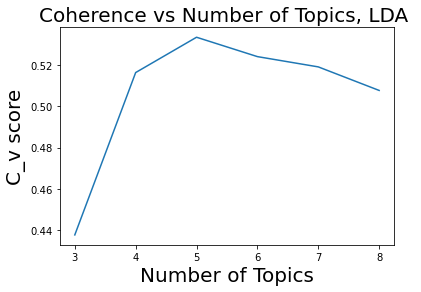

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
sns.lineplot(x=range(3,9),y=cohereldalist,ax=ax)
ax.set_xlabel('Number of Topics',fontsize=20)
ax.set_ylabel('C_v score',fontsize=20)
ax.set_title('Coherence vs Number of Topics, LDA ',fontsize=20)
fig.savefig('./Figures/LDA/C_v_vs_topics.png',bbox_inches='tight')

#The coherence is highest when there are 5 clusters (0.51)

ValueError: arrays must all be same length

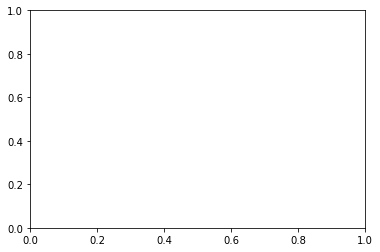

In [18]:
perplexitylist = []
for i in range(len(ldamodlist)):
    perplexitylist.append(ldamodlist[i].log_perplexity(corpus))




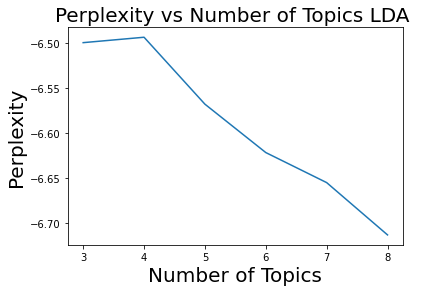

In [19]:
fig, ax = plt.subplots()
sns.lineplot(x=range(3,9),y=perplexitylist,ax=ax)
ax.set_xlabel('Number of Topics',fontsize=20)
ax.set_ylabel('Perplexity',fontsize=20)
ax.set_title('Perplexity vs Number of Topics LDA ',fontsize=20)
fig.savefig('./Figures/LDA/logperplexity_vs_topics.png',bbox_inches='tight')


In [8]:
len(ldamodlist)

8

### Saving 4-topic and 5-topic LDA models, and the dictionary.

In [20]:
# Save model to disk.
temp_file4topics = datapath("lda_nounsonly_4topics.gensim")
ldamodlist[1].save(temp_file4topics)


temp_file5topics = datapath("lda_nounsonly_5topics.gensim")
ldamodlist[2].save(temp_file5topics)

ldamod4t = LdaModel.load(temp_file4topics)
ldamod5t = LdaModel.load(temp_file5topics)


In [21]:
#saving the dictionary
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

pickle.dump(corpus, open('corpus_allreviews_nouns.pkl', 'wb'))
dictionary.save('dictionary_allreviews_nouns.gensim')


### Visualizing the 5 topic LDA model 

Circles correspond to different topics. Centers determined by multidimensional scaling of pairwise distances between topic vocabularies. Size of circle correspond to abundance of topic in the set of reviews.

In [22]:
#Visualize the LDA topics
dictionary = gensim.corpora.Dictionary.load('dictionary_allreviews_nouns.gensim')
corpus = pickle.load(open('corpus_allreviews_nouns.pkl', 'rb'))

temp_file = datapath("lda_nounsonly_5topics.gensim")
lda = gensim.models.ldamodel.LdaModel.load(temp_file)

lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)
pyLDAvis.save_html(lda_display,'./LDAresults/pyldavis.html')



### Saving the scores for each review for the 4 topic lda model

In [14]:
doclist1 = docldalist[1]
topicweights = []
for i in range(len(doclist1)):
    topicw = doclist1[i][0]
    toadd = [0 for i in range(4)]
    for (index,frac) in topicw:
        toadd[index] = frac
    topicweights.append(toadd)
topicweightdf = pd.DataFrame(topicweights)
topicweightdf.columns = ['t0','t1','t2','t3']

In [15]:
topicweightdf['alias'] = merged.alias
topicweightdf['date'] = merged.date
topicweightdf['reviewtxt'] = merged.reviewtxt
topicweightdf['mreviewtxt'] = merged.mreviewtxt
topicweightdf.head(5)
topicweightdf.to_csv('./LDAresults/ldatopicweights_allreviews_4topics.csv',index=False)

In [31]:
#Saving the top 20 words per topic
#Creating a data frame, to store the fraction of the top 10 words in each topic
results = []

for i in range(4):
    termtuples = lda.get_topic_terms(i)
    rank = 1
    for (dicti,prob) in termtuples:
        word = dictionary[dicti]
        wordinfo = [i, word, prob,rank]
        results.append(wordinfo)
        rank = rank+1
        
topwordsbytopic = pd.DataFrame(results)
topwordsbytopic.columns = ['ldatopic','word','probability','rank']
topwordsbytopic.to_csv('./LDAresults/ldatopwordsfor4topics.csv',index=False)

### Saving the scores for each review for the 5 topic lda model

In [36]:
doclist5 = docldalist[2]
topicweights = []
for i in range(len(doclist5)):
    topicw = doclist5[i][0]
    toadd = [0 for i in range(5)]
    for (index,frac) in topicw:
        toadd[index] = frac
    topicweights.append(toadd)
topicweightdf = pd.DataFrame(topicweights)
topicweightdf.columns = ['t0','t1','t2','t3','t4']

In [37]:
print(topicweightdf.shape)
print(topicweightdf.head(5))
merged.shape

(42644, 5)
         t0        t1        t2        t3        t4
0  0.325074  0.367406  0.269238  0.019133  0.019149
1  0.273011  0.264573  0.278797  0.172485  0.011133
2  0.011938  0.620166  0.238300  0.117712  0.011884
3  0.144966  0.767353  0.000000  0.079120  0.000000
4  0.022453  0.204202  0.443816  0.307095  0.022434


(42644, 33)

In [38]:
merged.reset_index(inplace=True)
print(merged.head(5))
topicweightdf = pd.concat([topicweightdf,merged[['alias','date','reviewtxt','mreviewtxt']]],axis=1)

topicweightdf.to_csv('./LDAresults/ldatopicweights_allreviews_5topics.csv',index=False)
topicweightdf.head(50)

   index                      id          name                    alias  \
0      0  DxeD4Jw3gsImI-olCOB0bA  Little Canal  little-canal-new-york-2   
1      1  DxeD4Jw3gsImI-olCOB0bA  Little Canal  little-canal-new-york-2   
2      2  DxeD4Jw3gsImI-olCOB0bA  Little Canal  little-canal-new-york-2   
3      3  DxeD4Jw3gsImI-olCOB0bA  Little Canal  little-canal-new-york-2   
4      4  DxeD4Jw3gsImI-olCOB0bA  Little Canal  little-canal-new-york-2   

   is_closed  review_count price  rating            transactions   latitude  \
0      False           115     $     4.0  ['pickup', 'delivery']  40.714309   
1      False           115     $     4.0  ['pickup', 'delivery']  40.714309   
2      False           115     $     4.0  ['pickup', 'delivery']  40.714309   
3      False           115     $     4.0  ['pickup', 'delivery']  40.714309   
4      False           115     $     4.0  ['pickup', 'delivery']  40.714309   

   ...  name_top5count reviewidx  shopidx        date revrating  \
0  ... 

,t0,t1,t2,t3,t4,alias,date,reviewtxt,mreviewtxt
0,0.325074,0.367406,0.269238,0.019133,0.019149,little-canal-new-york-2,2019-12-21,It was my first time to the Little Canal. I w...,it was my first time to the little canal i wa...
1,0.273011,0.264573,0.278797,0.172485,0.011133,little-canal-new-york-2,2019-12-19,Just moved to the area and although there are ...,just moved to the area and although there are ...
2,0.011938,0.620166,0.238300,0.117712,0.011884,little-canal-new-york-2,2019-12-14,"Daytime: cafe. Nighttime: chillest, coziest ba...",daytime: cafe nighttime: chillest coziest bar...
3,0.144966,0.767353,0.000000,0.079120,0.000000,little-canal-new-york-2,2019-11-04,I always end up in here after I go to the Metr...,i always end up in here after i go to the metr...
4,0.022453,0.204202,0.443816,0.307095,0.022434,little-canal-new-york-2,2019-10-26,Stopped here Sunday 10/11/19 late in the day a...,stopped here sunday / / late in the day afte...
5,0.034620,0.864022,0.033395,0.034628,0.033335,little-canal-new-york-2,2019-10-19,Super cute and great music choice! It's a grea...,super cute and great music choice it's a grea...
6,0.392851,0.454888,0.016872,0.016670,0.118719,little-canal-new-york-2,2019-10-12,Came in to do some work like many other people...,came in to do some work like many other people...
7,0.025401,0.164585,0.357979,0.426771,0.025264,little-canal-new-york-2,2019-09-22,best Cafe food in NYC... It's a small one pers...,best cafe food in it's a small one person kit...
8,0.025364,0.459881,0.026414,0.463250,0.025091,little-canal-new-york-2,2019-09-02,Stopped in here to kill some time while waitin...,stopped in here to kill some time while waitin...
9,0.916317,0.020781,0.020990,0.020980,0.020932,little-canal-new-york-2,2019-09-01,What a pleasant surprise! We walked by this pl...,what a pleasant surprise we walked by this pl...


In [39]:
#Saving the top 20 words per topic
#Creating a data frame, to store the fraction of the top 10 words in each topic
results = []

for i in range(5):
    termtuples = lda.get_topic_terms(i)
    rank = 1
    for (dicti,prob) in termtuples:
        word = dictionary[dicti]
        wordinfo = [i, word, prob,rank]
        results.append(wordinfo)
        rank = rank+1
        
topwordsbytopic = pd.DataFrame(results)
topwordsbytopic.columns = ['ldatopic','word','probability','rank']
topwordsbytopic.to_csv('./LDAresults/ldatopwordsfor5topics.csv',index=False)